# CSC448 - Assignment 3

## Abstract

For this assignment, I will dive into a very interesting datasets found on Kaggle.com titled "stroke prediction dataset". The link to the "stroke prediction dataset": https://www.kaggle.com/fedesoriano/stroke-prediction-dataset.

The dataset consist of relevant information of patients such as gender, age, various diseases, chronic issues and smoking status. Since I work part time at a medical office, I am curious to what cause patients to get a stroke. I will perform a linear regression on the dataset to predict the BMI based on the average glucose level. A high glucose level usually indicate a larger energy storage. If a person's body does not burn up the high amout of energy, it usually becomes fat storage. Since BMI is calculated by height and weight, the BMI could be predicted given the average glucose level. To further study the dataset, I will use this dataset to classify if a patient has stroke or not based on all the informations using k-Nearest Neighbors (KNN) algorithm. 

Let's "AI" the dataset now!

In [637]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, plot_confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

## Section 1: Prepping the Regression dataset
The stroke prediction dataset contain several columns with clincial information for each patient. Let's look at the first 15 rows of the original dataset first.

In [638]:
# Load the first 15 rows of the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/AiHuaLi-CS/CSC448/main/stroke_dataset.csv")
dataset.head(15)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


I will be using the following columns for linear regression for predicting the BMI given the average glucose level. 

* **avg_glucose_level**: average glucose level in blood
* **bmi**: body mass index

Before we move on, let's first clean the dataset by removing any rows with missing values for both avg_glucose_level and bmi. I will not apply the df.dropna() to the whole dataset because I am only looking at these two variables for linear regression, removing other rows due to other missing values will affect the outcome.

## Clean The Dataset

In [639]:
# Obtain only "avg_glucose_level" and "bmi" columns of the data
df = dataset.iloc[:,[8,9]] 
# Drop NaN data values in both columns
df_data = df.dropna()

print(df_data.skew(axis = 0))
print()
print(df_data.describe())

avg_glucose_level    1.614026
bmi                  1.055340
dtype: float64

       avg_glucose_level          bmi
count        4909.000000  4909.000000
mean          105.305150    28.893237
std            44.424341     7.854067
min            55.120000    10.300000
25%            77.070000    23.500000
50%            91.680000    28.100000
75%           113.570000    33.100000
max           271.740000    97.600000


we can see from description above that the average glucose level column has a skew value of 1.61 and the bmi column has a skew value of 1.05. Although both number indicate that the model is only moderately skewed, let's eliminate the outliers based on their z-scores calculated based on their mean and standard deviation for a more accurate prediction.

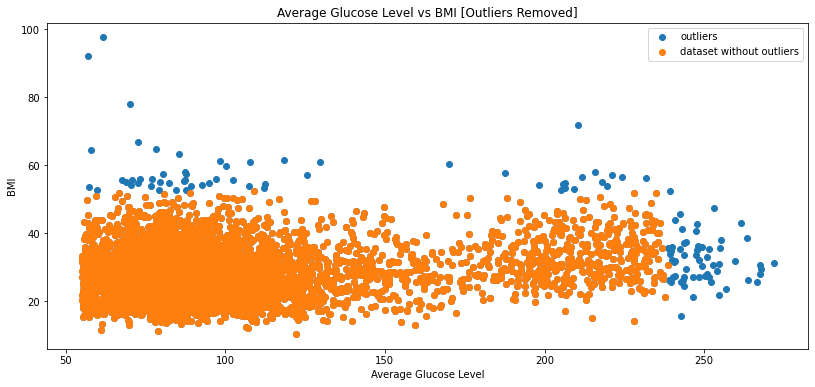

avg_glucose_level    1.602666
bmi                  0.472935
dtype: float64

       avg_glucose_level          bmi
count        4792.000000  4792.000000
mean          103.329631    28.501336
std            41.423369     7.149869
min            55.120000    10.300000
25%            76.777500    23.500000
50%            91.210000    27.900000
75%           112.315000    32.800000
max           238.530000    52.300000


In [640]:
f = plt.figure(figsize=(30,6))
p = plt.subplot(1, 2, 1)
p.scatter(df_data['avg_glucose_level'], df_data['bmi'], label = 'outliers')

# Outliers found and removed using the z scorers - remove if z-score >= 3
df = df_data[(np.abs(stats.zscore(df_data)) < 3).all(axis=1)]
p.set_xlabel("Average Glucose Level")
p.set_ylabel("BMI")
p.columns = ['removed']
p.plot(style = 'o')
p.set_title("Average Glucose Level vs BMI [Outliers Removed]")
p.scatter(df['avg_glucose_level'], df['bmi'], label = 'dataset without outliers')

plt.legend()
plt.show()
print(df.skew(axis = 0))
print()
print(df.describe())

We can see from the scatter plots above that the outliers from the avg_glucose_level and bmi have been removed. Although there's not much change to the skew value, it decresed from 1.61 to 1.60 for average glucose level and skew value for bmi decreased from 1.05 to 0.47. As we can see from the scatter plot, we can tell many outliers of the data pairs are removed. 

## Step 2: : Linear Regression 
### Split Data
We can now use sklearn to split our data into training and testing set
* x_train: average glucose level for training the regression model
* y_train: bmi used for training the regression model
* x_test: average glucose level for testing the regression model
* y_test: bmi for testing the regression model

In [641]:
x_train, x_test, y_train, y_test = train_test_split(df[['avg_glucose_level']], df[['bmi']], test_size=0.2, shuffle=True)
regression = LinearRegression().fit(x_train, y_train)


We used sklearn to randomly create a training set and testing set using the 'avg_glucose_level' and 'bmi'. 20% of the dataset was reserved for testing. Then, we proceed to use that training set and fit a Linear Regression model.

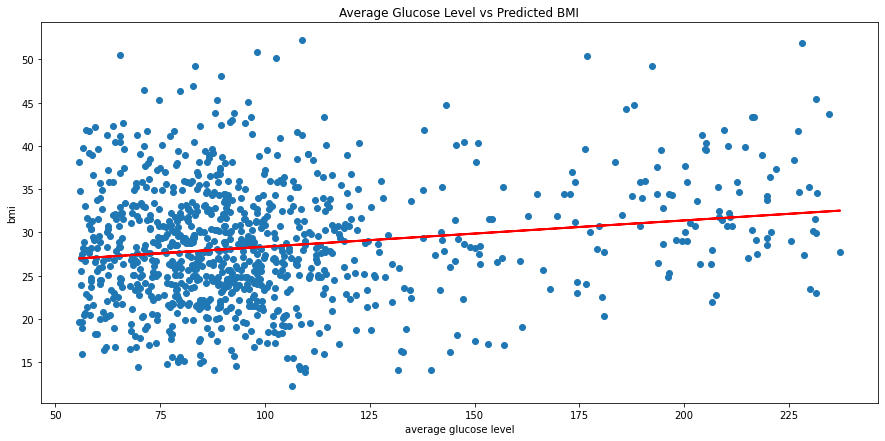

Mean squared error: 46.74860717255882
Coefficient of determination: 0.02999677361882913
K folds cross-validation mean: 0.026168780467132356


In [642]:
y_pred = regression.predict(x_test)

f = plt.figure(figsize=(15,7))
plt.title("Average Glucose Level vs Predicted BMI")
plt.xlabel("average glucose level")
plt.ylabel("bmi")
plt.scatter(x_test, y_test)
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.show()

print("Mean squared error: " + str(mean_squared_error(y_test, y_pred)))
print("Coefficient of determination: " + str(r2_score(y_test, y_pred)))
k_folds = cross_val_score(regression, X = x_train, y = y_train, cv = 10)
print("K folds cross-validation mean: " + str(np.mean(k_folds)))

## Linear Regression Conclusion

As we can see from the results we got from sklearn, the linear regression model didn't do a great job at making predictions for BMI given the average glucose level. The mean squared error which it's defined as the residual sum of squares in sklearn was about 46.8. This indicate that there a high difference between the trend line and the points as we can see from the scatter plot as well. The coefficient of determination is about 0.030 which it's extremely low as well. The regression model needs to be improved such as multi-variable regression because the dataset is very scattered. As we can see the mean values we got from k-folds cross-validation is almost equivalent to the coefficient of determination as well. 

## Section 3: Prepping the classification dataset

In order to perform the k-Nearest Neighbors (KNN) algorithm to classify if a patient has a stroke or not, I will need all columns or all features except the unique id of the dataset. The reason I chose to do a KNN classification is because the data is considered pretty scattered across the data as we seen from doing the linear regression. Using k neighbors to predict and classify if a patient might result better classification.

I briefly explain what each column represent in the stroke prediction dataset.

**gender**: Male, Female or Other\
**age**: age of the patient\
**hypertention**: 0 = patient doesn't hypertension, 1 = patient has hypertension\
**heart_disease**: 0 = patient doesn't hypertension, 1 = patient has hypertension\
**ever_married**: Yes or No\
**work_type**: children, Govt_jov, Never_worked, Private or Self-employed\
**Residence_type**: Rural or Urban\
**avg_glucose_level**: average glucose level in blood\
**bmi**: body mass index\
**smoking_status**: formerly smoked, never smoked, smokes or Unknown\
**stroke**: 1 = patient had a stroke, 0 = patient does not have a stroke\

Let's load the fist 15 rows of the dataset. 

In [643]:
# Load the first 15 rows of the dataset
dataset = pd.read_csv("https://raw.githubusercontent.com/AiHuaLi-CS/CSC448/main/stroke_dataset.csv")
dataset.head(15)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


## Clean The Dataset

Before we move on, let's first clean the dataset by removing any rows with missing values for all columns. Since there are several columns that contain strings instead of values, I will need to map thme using pandas.DataFrame.replace() to convert them to meaning full integers.

In [644]:
df = dataset.drop(columns = 'id')
df = df.dropna()
df = df[df['gender'] != "Other"]
df = df[df['smoking_status'] != "Unknown"]

number = LabelEncoder()
df["gender"] = number.fit_transform(df["gender"].astype('str'))
df["ever_married"] = number.fit_transform(df["ever_married"].astype('str'))
df["work_type"] = number.fit_transform(df["work_type"].astype('str'))
df["Residence_type"] = number.fit_transform(df["Residence_type"].astype('str'))
df["smoking_status"] = number.fit_transform(df["smoking_status"].astype('str'))

display(df)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,0,1
2,1,80.0,0,1,1,2,0,105.92,32.5,1,1
3,0,49.0,0,0,1,2,1,171.23,34.4,2,1
4,0,79.0,1,0,1,3,0,174.12,24.0,1,1
5,1,81.0,0,0,1,2,1,186.21,29.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5100,1,82.0,1,0,1,3,0,71.97,28.3,1,0
5102,0,57.0,0,0,1,2,0,77.93,21.7,1,0
5106,0,81.0,0,0,1,3,1,125.20,40.0,1,0
5107,0,35.0,0,0,1,3,0,82.99,30.6,1,0


The data has been cleaned and the following is a summary of changes that are made to columns with strings. Each string is mapped to a specific integer.

* **gender**: Male = 1, Female = 0, there was only 1 occurrence of other so it's removed
* **ever_married**: No = 0, Yes = 1
* **work_type**: Govt_jov = 0, Never_worked = 1, Private = 2, Self-employed = 3, children = 4
* **Residence_type**: Rural = 0, Urban = 1
* **smoking_status**: formerly smoked = 0, never smoked = 1, smokes = 2, unknown smoking status is removed because it will influence how the model will predict if smoking status causes stroke

We can now move to the actual classification model.

## Section 4: Classification with k-Nearest Neighbors (KNN)

### Split the data

In this section, we will use the k-Nearest Neighbors (KNN) classification to classify whether a patient has stroke or not based on their clinical and personal information. Before we start the classification, let's first use sklearn to split our data into training and testing set. 

* x_train: gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi and smoking_status for training the KNN model
* y_train: stroke used for training the KNN model
* x_test: gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi and smoking_status for testing the KNN model
* y_test: stroke for testing the KNN model

In [645]:
x = df[["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_status"]]
x_train, x_test, y_train, y_test = train_test_split(x, df[['stroke']], test_size=0.2, shuffle=True)

We used sklearn to randomly create a training set and testing set using all the features and the stroke values. 20% of the dataset was reserved for testing. Then, we proceed to use that training set and fit the KNN model. Before we actually apply the classification, we need to scale the dataset. 

## Feature Scaling

In [646]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

The k-nearest neighbor classification relies on selection of k "nearest" neighbors to vote on by distance such as Euclidean distance. Votes are weighted by distance. Since KNN is an example of "Lazy Learning", we know that it's necessary to scale down our data by normalizing it because data computation happens in runtime. By scaling it, we can speed up the learning time for knn model.

In [647]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(x_train, y_train.values.ravel())

y_pred = knn_model.predict(x_test)

There is no ideal value for K and it is selected after testing and evaluation. We will start with 5 because it seems to be the most commonly used value for KNN algorithm. y_pred will be our predictions on our test data.

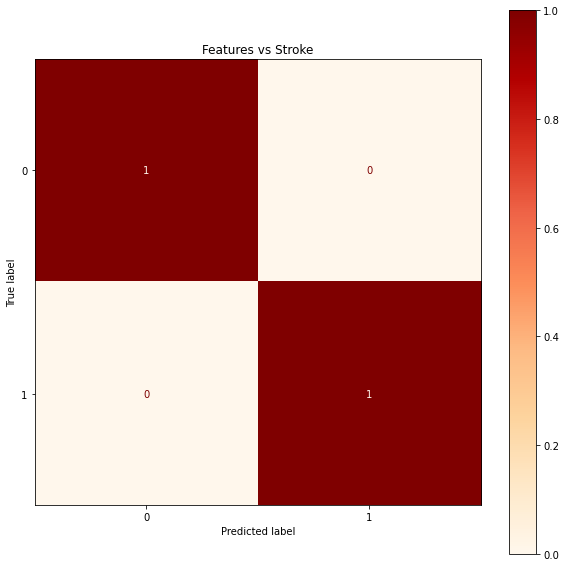

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       648
           1       0.00      0.00      0.00        37

    accuracy                           0.94       685
   macro avg       0.47      0.50      0.49       685
weighted avg       0.89      0.94      0.92       685

Training score of trained model 0.9496350364963504
Testing score of trained model 0.9445255474452555


In [648]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Features vs Stroke")
plot_confusion_matrix(knn_model, x_test, y_pred, ax = ax, cmap = "OrRd", normalize = 'true')
plt.show()

print(classification_report(y_test, y_pred))

train_score = knn_model.score(x_train, y_train)
print("Training score of trained model " + str(train_score))

test_score = knn_model.score(x_test, y_test)
print("Testing score of trained model " + str(test_score))

## k-Nearest Neighbors Classification Conclusion

The resulted test score compared to the train score is surprisingly close. I knew it would be classified easily by the dataset since there's only 2 categories determining if the patient ever had stroke or not. However, it might be overfitting since I did removed a huge group of patients where their smoking status were unknown. I will need to improve the model more perhaps by adding the unknown data back or try another classification method as well.